In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [351]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business', 'general'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [903]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 7216462#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

3225529
Title: "Hello, Li Huanying" is a hit, Douyin netizens use videos to record ordinary people's "Li Huanying" - TOM
Description: In this year's Spring Festival movie "Hello, Li Huanying," mother Li Huanying's delicate and selfless maternal love made countless viewers cry. In the movie, the story of a daughter living with her young mother has aroused countless netizens' enthusiasm for exploring their mother's youth. In the Douyin topic of "Going back in time and taking photos with my mother," many netizens posted "photos" of themselves and their mother when they were young, using the movie's ending song "Yilan Love Story" as the background music.
Original Language: Chinese


In [904]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: "Hello, Li Huanying" is a hit, Douyin netizens use videos to record ordinary people's "Li Huanying" - TOM
Description: In this year's Spring Festival movie "Hello, Li Huanying," mother Li Huanying's delicate and selfless maternal love made countless viewers cry. In the movie, the story of a daughter living with her young mother has aroused countless netizens' enthusiasm for exploring their mother's youth. In the Douyin topic of "Going back in time and taking photos with my mother," many netizens posted "photos" of themselves and their mother when they were young, using the movie's ending song "Yilan Love Story

In [905]:
##############################################
motivation_raw = '''
{
  "introduction": "The heartwarming movie 'Hello, Li Huanying' has inspired a wave of Douyin users to delve into their mothers' pasts, creating a unique blend of personal history and social media trends. By examining the number of videos posted under the 'Going back in time and taking photos with my mother' topic on Douyin, we can explore how this cinematic influence shapes online behavior. This look into the data will reveal trends in user engagement and the emotional resonance of the film's theme with the audience.",
  "title": "Cinematic_Influence_on_Douyin_User_Behavior"
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [906]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [913]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Douyin_User_Engagement",
    "description": "Level of user engagement in Douyin activities related to the movie 'Hello, Li Huanying'.",
    "type": "outcome",
    "observed": true,
    "values": ["Low engagement", "High engagement"],
    "parents": ["Social_Media_Influence", "Emotional_Resonance"]
  },
  {
    "name": "Exposure_to_Movie",
    "description": "Whether a user has watched the movie 'Hello, Li Huanying'.",
    "type": "treatment",
    "observed": true,
    "values": ["Not watched", "Watched"],
    "parents": ["Social_Media_Influence"]
  },
  {
    "name": "Interest_in_Mother's_Youth",
    "description": "User's interest in exploring their mother's youth.",
    "type": "treatment",
    "observed": true,
    "values": ["No interest", "Interested"],
    "parents": ["Exposure_to_Movie", "Cultural_Interest"]
  },
  {
    "name": "Social_Media_Influence",
    "description": "The influence of social media on the user's decisions and interests.",
    "type": "confounder",
    "observed": true,
    "values": ["Low influence", "High influence"],
    "parents": []
  },
  {
    "name": "Cultural_Interest",
    "description": "User's general interest in cultural activities and history.",
    "type": "confounder",
    "observed": false,
    "values": ["Not interested", "Interested"],
    "parents": []
  },
  {
    "name": "Personal_Historical_Interest",
    "description": "Interest in personal and family history.",
    "type": "mediator",
    "observed": true,
    "values": ["Not interested", "Interested"],
    "parents": ["Interest_in_Mother's_Youth", "Cultural_Interest"]
  },
  {
    "name": "Emotional_Resonance",
    "description": "The emotional impact of the movie on the user.",
    "type": "mediator",
    "observed": true,
    "values": ["No impact", "Impactful"],
    "parents": ["Personal_Historical_Interest", "Exposure_to_Movie"]
  },
  {
    "name": "Generational_Connection",
    "description": "Sense of connection with the user's generational heritage and family history.",
    "type": "collider",
    "observed": true,
    "values": ["Weak connection", "Strong connection"],
    "parents": ["Interest_in_Mother's_Youth", "Personal_Historical_Interest"]
  }
]

'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

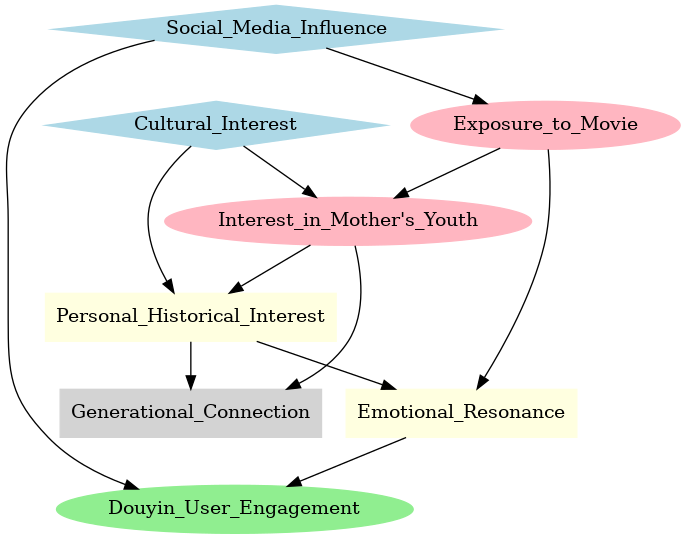

In [914]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [915]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

The heartwarming movie 'Hello, Li Huanying' has inspired a wave of Douyin users to delve into their mothers' pasts, creating a unique blend of personal history and social media trends. By examining the number of videos posted under the 'Going back in time and taking photos with my mother' topic on Douyin, we can explore how this cinematic influence shapes online behavior. This look into the data will reveal trends in user engagement and the emotional resonance of the film's theme with the audience.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their

In [916]:
#################################################

structure_raw = '''
[
    {"sentence": "The level of a user's engagement on Douyin, particularly in activities related to a specific movie, is influenced not just by their exposure to the movie, but also by the emotional impact it has on them, creating a nuanced picture of how cinematic content can shape online behavior.", "involved": ["Douyin_User_Engagement", "Emotional_Resonance", "Exposure_to_Movie"]},
    {"sentence": "Interestingly, the decision to watch the movie is partially shaped by the broader influence of social media, highlighting how online platforms can guide our choices in entertainment.", "involved": ["Exposure_to_Movie", "Social_Media_Influence"]},
    {"sentence": "The impact of the movie extends beyond mere entertainment, as it stirs up personal interest in family history, which in turn contributes to the emotional resonance felt by the viewer.", "involved": ["Emotional_Resonance", "Personal_Historical_Interest", "Interest_in_Mother's_Youth"]},
    {"sentence": "A user's general cultural interests, which may not be directly observable, play a role in fostering a deeper curiosity about their mother's youth after watching the movie.", "involved": ["Interest_in_Mother's_Youth", "Cultural_Interest"]},
    {"sentence": "This curiosity about a mother's youth, combined with a personal interest in family history, creates a unique sense of connection with one's generational heritage, a subtle but significant effect of the movie's theme.", "involved": ["Generational_Connection", "Interest_in_Mother's_Youth", "Personal_Historical_Interest"]},
    {"sentence": "Lastly, social media's pervasive influence also directly impacts how actively users engage with Douyin content, suggesting a powerful interplay between digital platforms and user behavior.", "involved": ["Douyin_User_Engagement", "Social_Media_Influence"]}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [917]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

The heartwarming movie 'Hello, Li Huanying' has inspired a wave of Douyin users to delve into their mothers' pasts, creating a unique blend of personal history and social media trends. By examining the number of videos posted under the 'Going back in time and taking photos with my mother' topic on Douyin, we can explore how this cinematic influence shapes online behavior. This look into the data will reveal trends in user engagement and the emotional resonance of the film's theme with the audience.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Social_Media_Influence" is "High influence" (rather than "Low influence")?
2. when "Social_Media_Influence" is "Low influence": what is the probability that "Exposure_to_Movie" is "Watched" (rather than "Not watched")?
3. when "

In [918]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.6, 0.7],
  "2": [0.3, 0.4],
  "3": [0.7, 0.8],
  "4": [0.5, 0.6],
  "5": [0.1, 0.2],
  "6": [0.4, 0.5],
  "7": [0.6, 0.7],
  "8": [0.8, 0.9],
  "9": [0.2, 0.3],
  "10": [0.5, 0.6],
  "11": [0.6, 0.7],
  "12": [0.8, 0.9],
  "13": [0.1, 0.2],
  "14": [0.4, 0.5],
  "15": [0.3, 0.4],
  "16": [0.7, 0.8],
  "17": [0.2, 0.3],
  "18": [0.5, 0.6],
  "19": [0.4, 0.5],
  "20": [0.7, 0.8],
  "21": [0.1, 0.2],
  "22": [0.3, 0.4],
  "23": [0.4, 0.5],
  "24": [0.7, 0.8]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [919]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions).item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

--------------------------  --------------  ---------------  ----------------------------------------------------------------------------------------
Exposure_to_Movie           Not watched     Watched          Whether a user has watched the movie 'Hello, Li Huanying'.
Interest_in_Mother's_Youth  No interest     Interested       User's interest in exploring their mother's youth.
Douyin_User_Engagement      Low engagement  High engagement  Level of user engagement in Douyin activities related to the movie 'Hello, Li Huanying'.
--------------------------  --------------  ---------------  ----------------------------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Social_Media_Influence' means The influence of social media on the user's decisions and interests.
'Exposure_to_Movie' means Whether a user has watched the movie 'Hello, Li Huanying'.
'Cultural_Interest' means User's general interest in cultural activities and history.
"Interest_in_Mother's_Youth" means User's interest in exploring their mother's youth.
'Personal_Historical_Interest' means Interest in personal and family history.
'Emotional_Resonance' means The emotional impact of the movie on the user.
'Douyin_User_Engagement' means Level of user engagement in Douyin activities related to the movie 'Hello, Li Huanying'.
'Generational_Connection' means Sense of connection with the user's generational heritage and family history.
Treatment Value    Treatment                   Outcome Value    Outcome                       ATE    Correlation
-----------------  --------------------------  ---------------  ----------------------  ---------  -------------
Watched            Exposure_to_Mov

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                    ATE    Correlation  Outcome
-----------------------------------------  -----  -------------  -----------------------------------------
High influence Social_Media_Influence       0.4            0.39  Watched Exposure_to_Movie
High influence Social_Media_Influence       0              0     Interested Cultural_Interest
High influence Social_Media_Influence       0.18           0.17  Interested Interest_in_Mother's_Youth
High influence Social_Media_Influence       0.05           0.05  Interested Personal_Historical_Interest
High influence Social_Media_Influence       0.17           0.16  Impactful Emotional_Resonance
High influence Social_Media_Influence       0.27           0.24  High engagement Douyin_User_Engagement
High influence Social_Media_Influence       0.08           0.06  Strong connection Generational_Connection
Watched Exposure_to_Movie                   0              0.39  High influence Social_Media_Influence
Watched Exposure_t

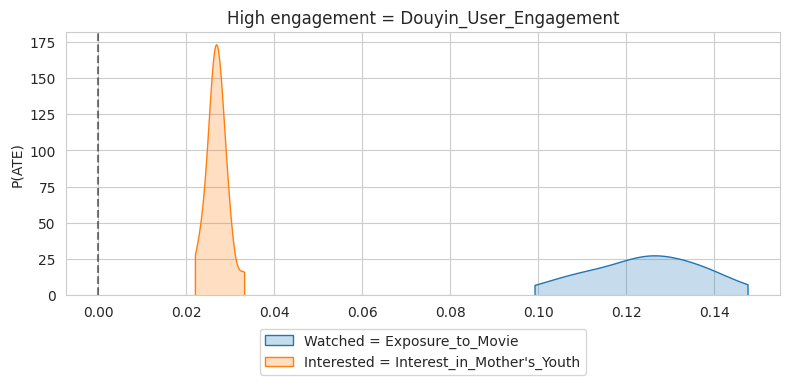

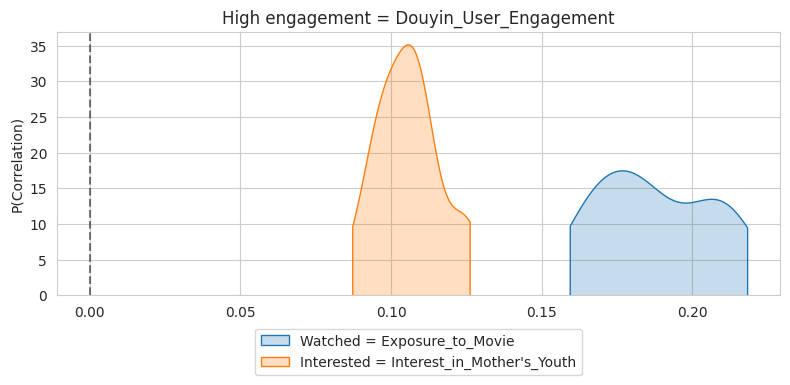

In [920]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [921]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Social_Media_Influence' (0='Low influence', 1='High influence') means The influence of social media on the user's decisions and interests.
Variable 'Exposure_to_Movie' (0='Not watched', 1='Watched') means Whether a user has watched th

In [922]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Social_Media_Influence": {
    "descriptor": ["the sway of social media", "social media's grip"],
    "subject": "social media",
    "predicate0": ["has a minimal effect on decisions", "holds little sway over interests"],
    "predicate1": ["dominates user decisions", "heavily influences interests"],
    "pronoun": "it",
    "nounclause0": ["social media has a minimal effect on decisions", "social media holds little sway over interests"],
    "nounclause1": ["social media dominates user decisions", "social media heavily influences interests"],
    "preposition": ["among", "in the case of"],
    "domain": "users",
    "subclause0": ["social media's influence is low", "there is minimal impact from social media"],
    "subclause1": ["social media wields significant influence", "the impact of social media is high"],
    "condition0": ["if social media influence is low", "where social media has minimal impact"],
    "condition1": ["if social media has a strong influence", "where social media's impact is high"],
    "action0": ["reducing social media's influence", "diminishing the impact of social media"],
    "action1": ["amplifying social media's influence", "enhancing the sway of social media"]
  },
  "Exposure_to_Movie": {
    "descriptor": ["viewership of 'Hello, Li Huanying'", "watching the movie"],
    "subject": "the audience",
    "predicate0": ["has not seen 'Hello, Li Huanying'", "remains unexposed to the movie"],
    "predicate1": ["has watched 'Hello, Li Huanying'", "is familiar with the movie"],
    "pronoun": "they",
    "nounclause0": ["the audience has not seen 'Hello, Li Huanying'", "the audience remains unexposed to the movie"],
    "nounclause1": ["the audience has watched 'Hello, Li Huanying'", "the audience is familiar with the movie"],
    "preposition": ["among", "within"],
    "domain": "viewers",
    "subclause0": ["a viewer has not seen the movie", "there is no exposure to the film"],
    "subclause1": ["a viewer has watched the movie", "there is familiarity with the film"],
    "condition0": ["if the movie is unwatched", "without exposure to the film"],
    "condition1": ["if the movie is watched", "with exposure to the film"],
    "action0": ["if someone skips 'Hello, Li Huanying'", "if a person doesn't watch the movie"],
    "action1": ["if someone watches 'Hello, Li Huanying'", "if a person views the movie"]
  },
  "Cultural_Interest": {
    "descriptor": ["engagement with culture", "interest in cultural activities"],
    "subject": "individuals",
    "predicate0": ["show no inclination towards cultural pursuits", "are disinterested in cultural history"],
    "predicate1": ["are drawn to cultural activities", "show a keen interest in cultural history"],
    "pronoun": "they",
    "nounclause0": ["individuals show no inclination towards cultural pursuits", "individuals are disinterested in cultural history"],
    "nounclause1": ["individuals are drawn to cultural activities", "individuals show a keen interest in cultural history"],
    "preposition": ["among", "within"],
    "domain": "people",
    "subclause0": ["a person lacks interest in culture", "there is no cultural curiosity"],
    "subclause1": ["a person is engaged in cultural activities", "there is a strong cultural curiosity"],
    "condition0": ["if cultural interest is absent", "without a cultural inclination"],
    "condition1": ["if there is a cultural interest", "with a cultural inclination"],
    "action0": ["losing interest in cultural activities", "becoming disinterested in cultural history"],
    "action1": ["developing an interest in cultural activities", "growing curious about cultural history"]
  },
  "Interest_in_Mother's_Youth": {
    "descriptor": ["curiosity about their mother's youth", "inclination to explore their mother's past"],
    "subject": "users",
    "predicate0": ["show no interest in their mother's younger days", "are not curious about their mother's past"],
    "predicate1": ["are keen to explore their mother's youth", "show a deep interest in their mother's younger days"],
    "pronoun": "they",
    "nounclause0": ["users are not curious about their mother's past", "there is no interest in exploring their mother's youth"],
    "nounclause1": ["users are keen to explore their mother's youth", "there is an interest in their mother's younger days"],
    "preposition": ["among", "within"],
    "domain": "users",
    "subclause0": ["a user shows no interest in their mother's past", "there is a lack of curiosity about their mother's youth"],
    "subclause1": ["a user is deeply interested in their mother's youth", "there is a strong curiosity about their mother's past"],
    "condition0": ["if users are not interested in their mother's youth", "when there is no curiosity about their mother's past"],
    "condition1": ["if users are interested in their mother's youth", "when they show a deep interest in their mother's past"],
    "action0": ["users lose interest in their mother's youth", "users stop exploring their mother's past"],
    "action1": ["users develop an interest in their mother's youth", "users start exploring their mother's past"]
  },
  "Personal_Historical_Interest": {
    "descriptor": ["interest in personal and family history", "engagement with family heritage"],
    "subject": "individuals",
    "predicate0": ["are not engaged with their family history", "show no interest in personal history"],
    "predicate1": ["are deeply engaged with their family history", "have a keen interest in personal history"],
    "pronoun": "they",
    "nounclause0": ["individuals are not interested in their family history", "there is no engagement with personal history"],
    "nounclause1": ["individuals have a keen interest in family history", "there is a deep engagement with personal history"],
    "preposition": ["among", "within"],
    "domain": "people",
    "subclause0": ["an individual shows no interest in their family history", "there is a lack of engagement with personal history"],
    "subclause1": ["an individual is deeply interested in their family history", "there is a strong engagement with personal history"],
    "condition0": ["if there is no interest in family history", "when personal history is overlooked"],
    "condition1": ["if there is an interest in family history", "when individuals engage with their personal history"],
    "action0": ["people lose interest in their family history", "engagement with personal history diminishes"],
    "action1": ["people become interested in their family history", "engagement with personal history increases"]
  },
  "Emotional_Resonance": {
    "descriptor": ["emotional impact of the movie", "movie's emotional effect"],
    "subject": "the film",
    "predicate0": ["leaves no lasting emotional impact", "fails to resonate emotionally"],
    "predicate1": ["has a profound emotional impact", "resonates deeply with viewers"],
    "pronoun": "it",
    "nounclause0": ["the film does not affect viewers emotionally", "there is no emotional resonance from the movie"],
    "nounclause1": ["the film deeply affects viewers emotionally", "there is a significant emotional resonance from the movie"],
    "preposition": ["in", "among"],
    "domain": "viewers",
    "subclause0": ["the movie fails to leave an emotional mark", "there is no emotional effect from the film"],
    "subclause1": ["the movie leaves a profound emotional impact", "there is a deep emotional effect from the film"],
    "condition0": ["if the movie does not resonate emotionally", "when the film leaves no emotional impact"],
    "condition1": ["if the movie resonates emotionally", "when the film has a profound emotional impact"],
    "action0": ["the movie fails to touch viewers emotionally", "the emotional resonance of the film is lost"],
    "action1": ["the movie deeply touches viewers emotionally", "the emotional resonance of the film is heightened"]
  },
  "Douyin_User_Engagement": {
    "descriptor": ["level of engagement on Douyin", "user activity related to the movie on Douyin"],
    "subject": "users",
    "predicate0": ["show limited activity related to the movie", "are not very active on Douyin regarding the film"],
    "predicate1": ["are highly active in discussions about the movie", "show significant engagement on Douyin related to the film"],
    "pronoun": "they",
    "nounclause0": ["users are minimally engaged on Douyin regarding the movie", "there is low user activity related to the film on Douyin"],
    "nounclause1": ["users are highly engaged on Douyin regarding the movie", "there is high user activity related to the film on Douyin"],
    "preposition": ["among", "within"],
    "domain": "Douyin users",
    "subclause0": ["a user shows minimal engagement with the movie on Douyin", "there is limited user activity on Douyin about the film"],
    "subclause1": ["a user is highly engaged with the movie on Douyin", "there is significant user activity on Douyin about the film"],
    "condition0": ["if users are not active on Douyin about the movie", "when there is little engagement with the film on Douyin"],
    "condition1": ["if users are active on Douyin about the movie", "when there is significant engagement with the film on Douyin"],
    "action0": ["user activity on Douyin decreases", "engagement with the movie on Douyin diminishes"],
    "action1": ["user activity on Douyin increases", "engagement with the movie on Douyin intensifies"]
  },
  "Generational_Connection": {
    "descriptor": ["sense of connection with generational heritage", "feeling of kinship with family history"],
    "subject": "individuals",
    "predicate0": ["feel a weak connection to their generational heritage", "lack a strong bond with their family history"],
    "predicate1": ["feel a strong connection to their generational heritage", "have a deep bond with their family history"],
    "pronoun": "they",
    "nounclause0": ["individuals feel a weak bond with their generational heritage", "there is a lack of connection to family history"],
    "nounclause1": ["individuals feel a strong bond with their generational heritage", "there is a deep connection to family history"],
    "preposition": ["among", "within"],
    "domain": "people",
    "subclause0": ["an individual feels a weak connection to their generational heritage", "there is a lack of kinship with family history"],
    "subclause1": ["an individual feels a strong connection to their generational heritage", "there is a deep kinship with family history"],
    "condition0": ["if there is a weak connection to generational heritage", "when the bond with family history is lacking"],
    "condition1": ["if there is a strong connection to generational heritage", "when the bond with family history is strong"],
    "action0": ["the connection to generational heritage weakens", "the bond with family history diminishes"],
    "action1": ["the connection to generational heritage strengthens", "the bond with family history deepens"]
  }
}
'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)
assert all(node['name'] in ctx['verbs'] for node in nodes)

In [923]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

The heartwarming movie 'Hello, Li Huanying' has inspired a wave of Douyin users to delve into their mothers' pasts, creating a unique blend of personal history and social media trends. By examining the number of videos posted under the 'Going back in time and taking photos with my mother' topic on Douyin, we can explore how this cinematic influence shapes online behavior. This look into the data will reveal trends in user engagement and the emotional resonance of the film's theme with the audience.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Exposure_to_Movie') < 0
	2. ATE("Interest_in_Mother's_Youth") < 0
	3. ATE('Exposure_to_Movie') < ATE("Interest_in_Mother's_Youth")
	4. |ATE("Interest_in_Mother's_Youth")| > |ATE('Exposure_to_Movie')|
	5. CAT

In [924]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {
        "question": "Does watching 'Hello, Li Huanying' tend to decrease a user's overall engagement on Douyin?",
        "answer": "yes",
        "claim": "Watching the movie 'Hello, Li Huanying' generally leads to a decrease in Douyin engagement."
    },
    "2": {
        "question": "Is being interested in one's mother's youth associated with a reduction in Douyin activity?",
        "answer": "yes",
        "claim": "Interest in exploring one's mother's youth correlates with decreased activity on Douyin."
    },
    "3": {
        "question": "Is the impact of watching 'Hello, Li Huanying' on Douyin engagement less than the impact of interest in one's mother's youth?",
        "answer": "yes",
        "claim": "The influence of watching 'Hello, Li Huanying' on Douyin engagement is less than the effect of being interested in one's mother's youth."
    },
    "4": {
        "question": "Is the magnitude of the impact of interest in one's mother's youth on Douyin engagement greater than that of watching the movie?",
        "answer": "yes",
        "claim": "The overall effect of interest in one's mother's youth on Douyin engagement is more pronounced than that of watching 'Hello, Li Huanying'."
    },
    "5": {
        "question": "For users less influenced by social media, does watching 'Hello, Li Huanying' decrease their Douyin engagement?",
        "answer": "yes",
        "claim": "Among users with low social media influence, watching 'Hello, Li Huanying' tends to reduce their activity on Douyin."
    },
    "6": {
        "question": "For those less influenced by social media, is being interested in one's mother's youth linked to lower Douyin activity?",
        "answer": "yes",
        "claim": "Users less influenced by social media show reduced Douyin activity when they are interested in their mother's youth."
    },
    "7": {
        "question": "For users with low social media influence, does interest in one's mother's youth have a greater impact on Douyin engagement compared to watching the movie?",
        "answer": "yes",
        "claim": "Among users less swayed by social media, the impact of interest in their mother's youth on Douyin activity surpasses that of watching 'Hello, Li Huanying'."
    },
    "8": {
        "question": "Is the absolute impact of interest in one's mother's youth on Douyin engagement larger than that of watching the movie among those with low social media influence?",
        "answer": "yes",
        "claim": "For users with minimal social media influence, the absolute effect of their interest in their mother's youth on Douyin activity is more significant than the effect of watching 'Hello, Li Huanying'."
    },
    "9": {
        "question": "For users highly influenced by social media, does watching 'Hello, Li Huanying' increase their engagement on Douyin?",
        "answer": "yes",
        "claim": "Among users heavily influenced by social media, watching 'Hello, Li Huanying' typically leads to increased activity on Douyin."
    },
    "10": {
        "question": "For those heavily influenced by social media, is being interested in one's mother's youth associated with increased Douyin activity?",
        "answer": "yes",
        "claim": "Users with a high degree of social media influence exhibit increased Douyin engagement when they show interest in their mother's youth."
    },
    "11": {
        "question": "Among users with high social media influence, does interest in one's mother's youth have a more substantial effect on Douyin engagement than watching the movie?",
        "answer": "yes",
        "claim": "For users highly influenced by social media, the impact of interest in their mother's youth on Douyin engagement exceeds the impact of watching 'Hello, Li Huanying'."
    },
    "12": {
        "question": "Is the absolute impact on Douyin engagement from watching 'Hello, Li Huanying' greater than that of interest in one's mother's youth among users highly influenced by social media?",
        "answer": "yes",
        "claim": "In the group with high social media influence, the absolute effect of watching 'Hello, Li Huanying' on Douyin activity is stronger than the effect of interest in one's mother's youth."
    },
    "13": {
        "question": "Does the effect of watching 'Hello, Li Huanying' on Douyin engagement differ between users with high and low social media influence?",
        "answer": "yes",
        "claim": "The effect of watching 'Hello, Li Huanying' on Douyin engagement varies between users with high and low social media influence."
    },
    "14": {
        "question": "Is the absolute effect of watching the movie on Douyin engagement smaller among users with high social media influence compared to those with low influence?",
        "answer": "yes",
        "claim": "The absolute impact of watching 'Hello, Li Huanying' on Douyin activity is lesser among users with high social media influence than those with low influence."
    },
    "15": {
        "question": "Among users with high social media influence, is the effect of being interested in one's mother's youth on Douyin engagement less than among those with low influence?",
        "answer": "yes",
        "claim": "The effect of interest in one's mother's youth on Douyin engagement is reduced among users with high social media influence compared to those with low influence."
    },
    "16": {
        "question": "Is the absolute effect of interest in one's mother's youth on Douyin engagement larger among users with low social media influence compared to those with high influence?",
        "answer": "yes",
        "claim": "The absolute impact of interest in one's mother's youth on Douyin activity is greater among users with low social media influence than those with high influence."
    },
    "17": {
        "question": "For users not interested in cultural activities, does watching 'Hello, Li Huanying' increase their Douyin engagement?",
        "answer": "yes",
        "claim": "Among users with no interest in cultural activities, watching 'Hello, Li Huanying' tends to increase their activity on Douyin."
    },
    "18": {
        "question": "For those not interested in cultural activities, is being interested in one's mother's youth linked to lower Douyin activity?",
        "answer": "yes",
        "claim": "Users not interested in cultural activities show reduced Douyin activity when they are interested in their mother's youth."
    },
    "19": {
        "question": "Among users not interested in cultural activities, does interest in one's mother's youth have a greater impact on Douyin engagement compared to watching the movie?",
        "answer": "yes",
        "claim": "For users disinterested in cultural activities, the impact of interest in their mother's youth on Douyin activity surpasses that of watching 'Hello, Li Huanying'."
    },
    "20": {
        "question": "Is the absolute impact of interest in one's mother's youth on Douyin engagement smaller than that of watching the movie among those not interested in cultural activities?",
        "answer": "yes",
        "claim": "Among users not interested in cultural activities, the absolute effect of their interest in their mother's youth on Douyin activity is less than the effect of watching 'Hello, Li Huanying'."
    },
    "21": {
        "question": "For users interested in cultural activities, does watching 'Hello, Li Huanying' decrease their engagement on Douyin?",
        "answer": "yes",
        "claim": "Among users interested in cultural activities, watching 'Hello, Li Huanying' typically leads to a decrease in activity on Douyin."
    },
    "22": {
        "question": "For those interested in cultural activities, is being interested in one's mother's youth associated with reduced Douyin activity?",
        "answer": "yes",
        "claim": "Users with an interest in cultural activities exhibit reduced Douyin engagement when they show interest in their mother's youth."
    },
    "23": {
        "question": "Among users interested in cultural activities, does interest in one's mother's youth have a more substantial effect on Douyin engagement than watching the movie?",
        "answer": "yes",
        "claim": "For users interested in cultural activities, the impact of interest in their mother's youth on Douyin engagement exceeds the impact of watching 'Hello, Li Huanying'."
    },
    "24": {
        "question": "Is the absolute impact on Douyin engagement from watching 'Hello, Li Huanying' smaller than that of interest in one's mother's youth among users interested in cultural activities?",
        "answer": "yes",
        "claim": "In the group interested in cultural activities, the absolute effect of watching 'Hello, Li Huanying' on Douyin activity is lesser than the effect of interest in one's mother's youth."
    }}
'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [925]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Cinematic_Influence_on_Douyin_User_Behavior.json'